# Price elasticity and Profit Maximisation

## Assumptions

### Сильные

1. Клиенты не имеют предпочтений кроме цены к детскому центру

*Так как выборка данных не репрезентативна на уровне предприятия мы не можем судить о 
брендовых предпочтений клиентов. Следовательно центром нашего анализа будет выступать
цена.*

2. Регион города Симферополя не влияет на предпочтения клиентов также сильно как цена

*Так как целью анализа является влияние цены на спрос, на первом этапе мы не обращаем внимание
на разницу в районах города.*

### Слабые

1. Ценовой регион в г.Симферополь отличается от ценового региона других городов Крыма

*Типаж городов разный а значит мы фокусируем наше внимание на анализ по г. Симферополь.*

2. Присутствует достаточно сильный сезонный эффект

*Анализ будет проведен посезонно.*

3. Присутствует достаточно сильный эффект выходного дня

*Эластичность спроса зависит от того выходной ли день в момент покупки билета.*

4. Родителям менее важна цена взрослого билета

*Предварительный анализ будет проведен на уровне цены Детского билета (СВП Детские)*

5. Месяц и очередность месяцев не имеют такого большого значения как тип сезона (Слабый / Сильный / Средний)

## Нормализация

Нормализация в данном случае происходит в 2х частях

1 - Мы распределяем цены по ведрам (30-50 ведер должно быть достаточно) тем самым сглаживая функцию по оси цены  
2 - Мы берем натуральный логарифм количества тем самым сглаживая эффект случайных клиентов


## Внешний вид функции

Согласно экономической теории функция спроса принимает или линейный вид с негативным наклоном или concave квадратичной фунции  
Рассмотрим оба варианта


## Чистка данных

In [680]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import calendar

In [681]:
df = pd.read_excel('./СРВЗВ наценка от 31.01.2020.xlsx', sheet_name='Данные')

In [682]:
df.head()

,Тип,Дата,Район,Стоимость билета,Человек,Сумма (руб.),День недели,Период
0,1. СВП Детские,2018-03-28,Киевский р-н СМФ,940.0,2,1880,среда,2018-03-31
1,1. СВП Детские,2019-02-12,Судак,500.0,2,1000,вторник,2019-02-28
2,1. СВП Детские,2018-02-19,Другой город,640.0,2,1280,понедельник,2018-02-28
3,1. СВП Детские,2018-02-10,Бахчисарайский р-н,720.0,4,2880,суббота,2018-02-28
4,1. СВП Детские,2019-10-08,,500.0,16,8000,вторник,2019-10-31


In [683]:
# Английские колонки для удобства

df.columns = ['Type', 'Date', 'Region', 'Price', 'Qt', 'Sum', 'Day', 'Period']

In [684]:
# Конвертация и фильтр данных
df.Price = df.Price.astype(float)
# Фильтруем неполные данные
df = df[df.Qt != ' ']
df.Qt = df.Qt.astype(int)

In [942]:
# Дополнительные функции

def which_season(x):
    '''Возвращает тип сезона исходя из переменной типа Timestamp'''
    if x.month in [3, 4, 5, 9, 10, 11]:
        return 'weak'
    if x.month in [6, 7, 8]:
        return 'not-season'
    else:
        return 'season'

def if_weekday(x):
    '''Возвращает рабочий == 1 / нерабочий == 0 день исходя из названия дня недели'''
    if x in ['суббота', 'воскресенье']:
        return 0
    else:
        return 1
    
def interval_mean(x):
    binned_df = df_target[df_target.Bins == x]
    return binned_df.Price.mean()
    return x.mid

def get_roots(ols, param_a, param_b, param_c, a_multi=1, b_multi=1):
    '''Получить корни квадратного уравнения'''
    a = ols.params.get(param_a) * a_multi
    b = ols.params.get(param_b) * b_multi
    c = ols.params.get(param_c)
    if c is None:
        c = 0
    print(f'Параметры квадратной функции a: {a}, b: {b}, c:{c}')
    x1 = (-b + np.sqrt(np.square(b) - (4*a*c)) ) / (2*a)
    x2 = (-b - np.sqrt(np.square(b) - (4*a*c) )) / (2*a)
    return x1, x2

## Создание дополнительных переменных

In [686]:
# Создаем новые переменные

df['Workday'] = df.Day.apply(if_weekday)
df['Season'] = df.Date.apply(which_season)
df['Year'] = df.Date.apply(lambda x: x.year)
df['Month'] = df.Date.apply(lambda x: calendar.month_name[x.month])

In [687]:
df.head()

,Type,Date,Region,Price,Qt,Sum,Day,Period,Workday,Season,Year,Month
0,1. СВП Детские,2018-03-28,Киевский р-н СМФ,940.0,2,1880,среда,2018-03-31,1,weak,2018,March
1,1. СВП Детские,2019-02-12,Судак,500.0,2,1000,вторник,2019-02-28,1,season,2019,February
2,1. СВП Детские,2018-02-19,Другой город,640.0,2,1280,понедельник,2018-02-28,1,season,2018,February
3,1. СВП Детские,2018-02-10,Бахчисарайский р-н,720.0,4,2880,суббота,2018-02-28,0,season,2018,February
4,1. СВП Детские,2019-10-08,,500.0,16,8000,вторник,2019-10-31,1,weak,2019,October


In [1084]:
# фильтруем датасет исходя из предположений

# Указать тип сезона
target_season = 'not-season' # weak / season / not-season
target_year = 2019 # 2018 / 2019
target_day = 1 # 1 для рабочего дня 0 для нерабочего дня
target_ticket = '1. СВП Детские'
bins = 40

def filter_df(df, target_ticket, target_year, target_season, target_day):
    df_target = df[df.Season == target_season]
    df_target = df_target[df.Type.str.contains(target_ticket)]
#     if target_season == 'season':
#         df_target = df_target[((df.Year == target_year) & (df.Month != 'December')) | ((df.Year == target_year-1) & (df.Month == 'December'))]
#     else:
#         df_target = df_target[df.Year == target_year]
#    df_target = df_target[df.Month == 'December']
    df_target = df_target[(df.Region.str.contains('р-н')) | (df.Region == ' ')]
    df_target = df_target[df.Workday == target_day]
    
    return df_target

df_target = filter_df(df, target_ticket, target_year,  target_season, target_day)


# распределяем цену по бакетам
df_target['Bins'] = pd.cut(df_target.Price, bins)
df_target['AvPrice'] = df_target.Bins.apply(interval_mean)
df_target.AvPrice = df_target.AvPrice.astype(float)
bins = df_target[['Bins', 'AvPrice']]
df_target = df_target.groupby(by=['AvPrice']).sum().reset_index()

df_target = df_target[['Qt', 'AvPrice']]

data = pd.DataFrame({'q': df_target.Qt, 'a_price': df_target.AvPrice})

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


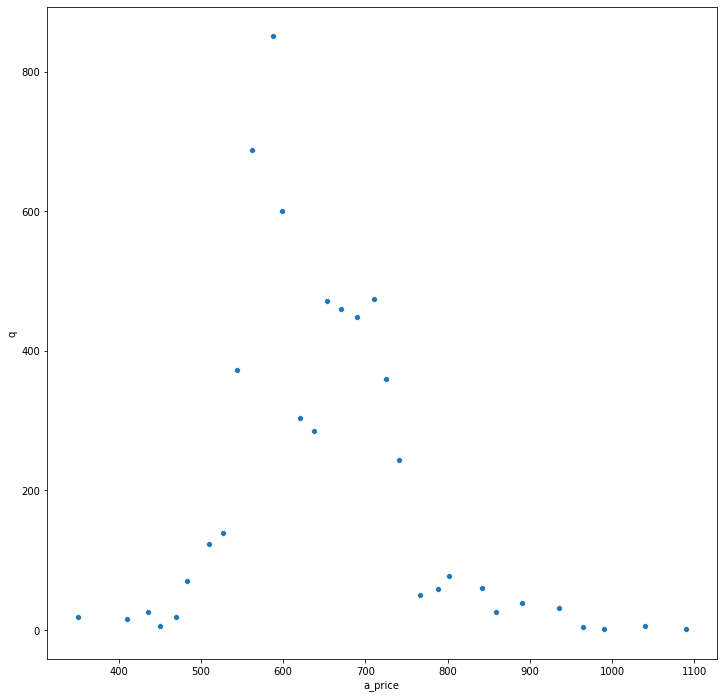

In [1085]:
# представляем визуально распределение цены / количества
fix, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(y='q', x='a_price', data=data)

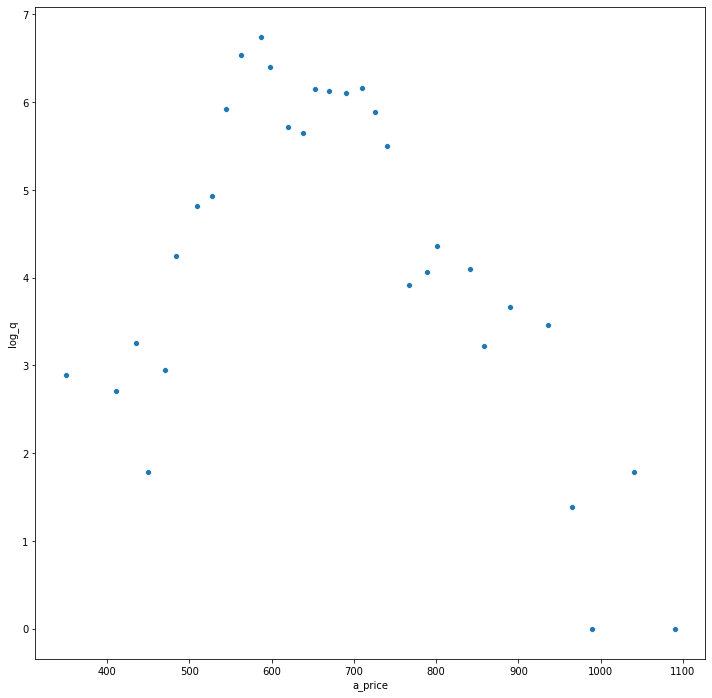

In [1086]:
temp = data
# Нижняя левая часть явно является нерепрезентативной для анализа цены, фильтруем исходя из средней цены
temp['log_q'] = np.log(data.q)
temp = temp[['log_q', 'a_price']]
#temp = data[~((data.log_q < 3) & (data.a_price < data.a_price.mean())) ]
# Аргументация: При 1ом предположении при низкой цене спрос должен расти выше предложения - так как спрос позитивный и соседние ведра явно содержат наблюдения
# мы фильтруем эти значения не смотря на невысокий Z-score (таким образом мы повышваем предвзятость модели но сильно уменьшаем варианс)
# представляем визуально распределение цены / количества
fix, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(y='log_q', x='a_price', data=temp)

## Получение экстренумов как максимизация дохода

### Формулы

TR (Total revenue) = Quantity * Price

$log(Quantity) = a * p^{2} + b*p + c$

Где log - натуральный логарифм
Так как натуральный логарифм это безопасное симметричное преобразование
мы можем его сокращать следующим путем:

$log(Quantity) = a * p^{2} + b*p + c$  
$Q = (a * p^{2} + b*p + c)^{e}$

Подставляем в формулу дохода

$TR = (ap^{2} + bp + c)^{e} * p$

## Первая функиця - квадратичная с интерcептом
Для максимизации прибыли берем первый дериватив и прировнять к 0 - с интерцептом

$dTR/dp = (ap ^ {2} + bp + c)^{e-1} ((2e+1)ap^{2} + (e+1)bp + c) =^{!} 0$

Очевидно что при этом одна из частей мультипликации должна равняться 0

часть $(ap ^ {2} + bp + c)^{e-1}$ приравнивается к $(ap ^ {2} + bp + c)$ 
и имеет стандартные корни

часть $((2e+1)ap^{2} + (e+1)bp + c)$ это обычное квадратное уравнение

In [1100]:
# Квадратное распределение с интерсептом
ols_intercept = smf.ols('log_q ~ np.square(a_price) + a_price', data=temp).fit()
print(ols_intercept.summary())

                            OLS Regression Results                            
Dep. Variable:                  log_q   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     45.71
Date:                Sun, 02 Feb 2020   Prob (F-statistic):           1.52e-09
Time:                        23:03:16   Log-Likelihood:                -40.813
No. Observations:                  31   AIC:                             87.63
Df Residuals:                      28   BIC:                             91.93
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -10.6583      2

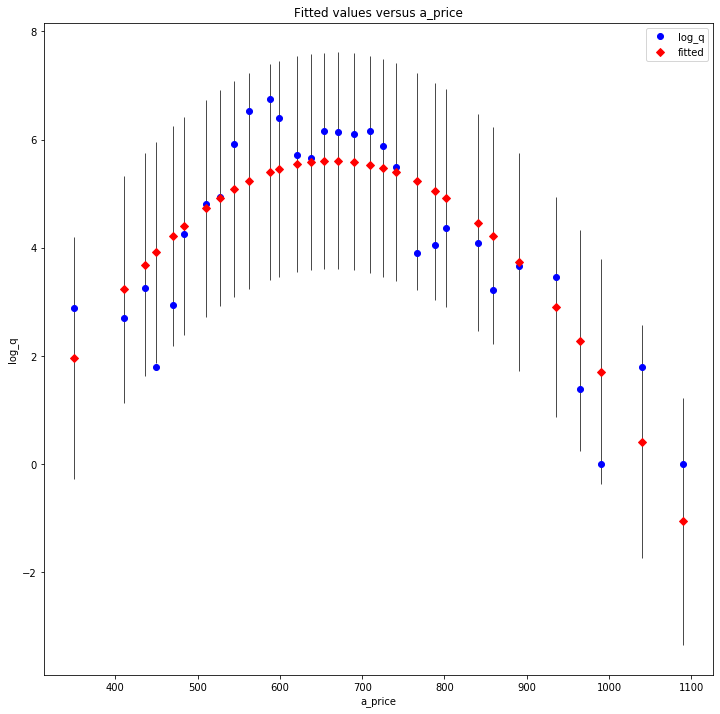

In [1101]:
fix, ax = plt.subplots(figsize=(12,12))
fig = sm.graphics.plot_fit(ols_intercept, 'a_price', data=temp, ax=ax)

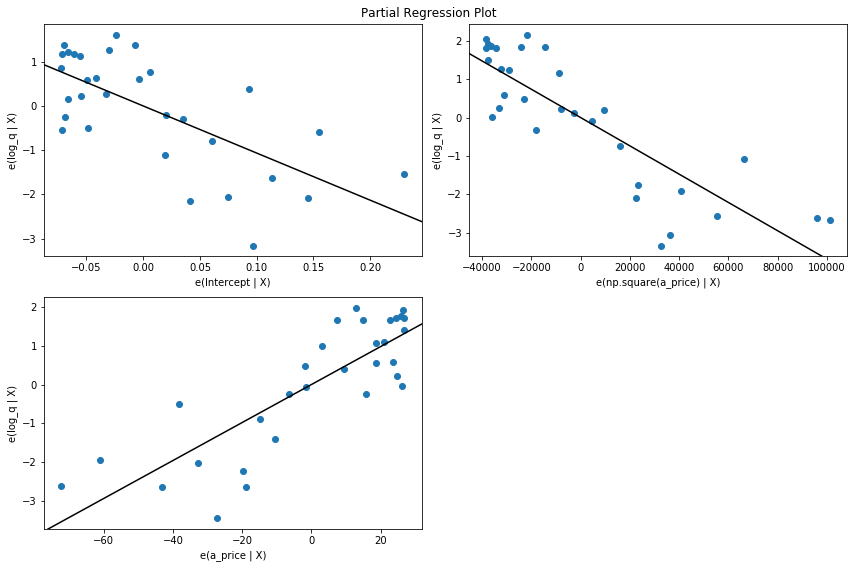

In [1089]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(ols_intercept, fig=fig)

In [1090]:
# первая функция - c интерцептом
param_a = 'np.square(a_price)'
param_b = 'a_price'
param_c = 'Intercept'

roots1 = get_roots(ols_intercept, param_a, param_b, param_c)
print(f'Левая часть {roots1}')
roots2 = get_roots(ols_intercept, param_a, param_b, param_c, a_multi = ( (2*np.e) + 1), b_multi = (np.e + 1))
print(f'Правая часть {roots2}')

Параметры квадратной функции a: -3.684723313552867e-05, b: 0.04897117699275575, c:-10.658341774537412
Левая часть (274.2287816273505, 1054.8038980485892)
Параметры квадратной функции a: -0.00023716956165813186, b: 0.18208863753041538, c:-10.658341774537412
Правая часть (63.84262517638639, 703.9145703818156)


Мы можем провести тест по нахождению единственного из 4х экстренумов но в случае квадратичной функции вполне очевидно
какое из значений верное (см график, максималный корень второго уравнения)

## Вторая функция - квадратичная без интерцепта приводится к следующей форме

$\dfrac{\left(\left(2\mathrm{e}+1\right)ax+\left(\mathrm{e}+1\right)b\right)\left(ax^2+bx\right)^\mathrm{e}}{ax+b}$

Очевидно что левая половина возвращает отрицательную или слишком низкую цену что нам не подходит.  
Правая часть формулы - обычное квадратное уравнение с с = 0

$\left(ax^2+ax\right)$

In [1091]:
# Квадратное распределение без интерсепта
ols_no_intercept = smf.ols('log_q ~ np.square(a_price) + a_price - 1', data=temp).fit()
print(ols_no_intercept.summary())

                                 OLS Regression Results                                
Dep. Variable:                  log_q   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.923
Method:                 Least Squares   F-statistic:                              186.4
Date:                Sun, 02 Feb 2020   Prob (F-statistic):                    2.81e-17
Time:                        22:53:39   Log-Likelihood:                         -50.570
No. Observations:                  31   AIC:                                      105.1
Df Residuals:                      29   BIC:                                      108.0
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

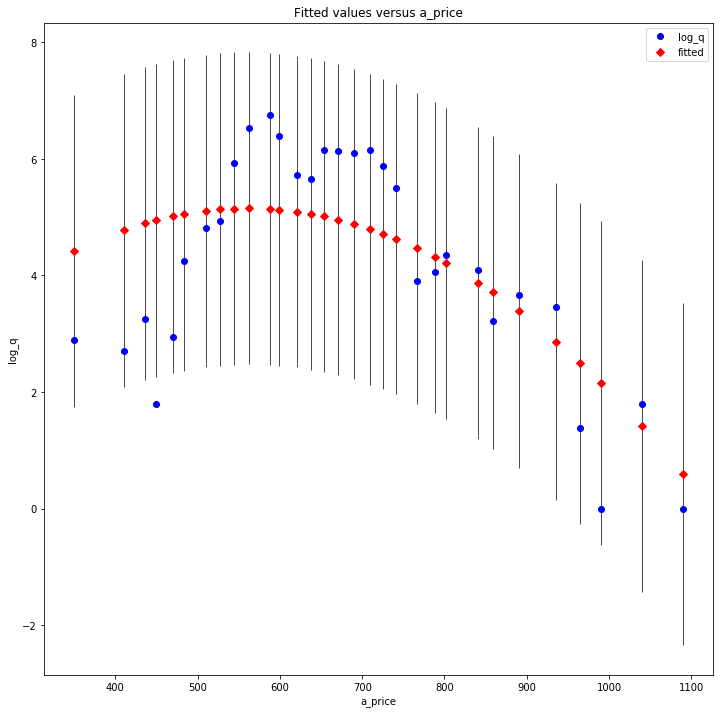

In [1092]:
fix, ax = plt.subplots(figsize=(12,12))
fig = sm.graphics.plot_fit(ols_no_intercept, 'a_price', data=temp, ax=ax)

In [1093]:
# вторая функция - квадратичная без интерcепта
param_a = 'np.square(a_price)'
param_b = 'a_price'
param_c = ''

a = ols_no_intercept.params.get(param_a)
b = ols_no_intercept.params.get(param_b)

roots3 = (-b*(np.e+1)) / ((2*np.e + 1) * a)
print(f'Левая часть {roots3}')
roots4 = - b / a
print(f'Правая часть {roots4}')

print('Первый корень очевидный выбор')

Левая часть 648.7989899724918
Правая часть 1123.1090573983645
Первый корень очевидный выбор


## Третья функция - линейная 

в этом случае нам более интересна функция цены


$log(Q) = ap + c$

$ p = \frac{log(Q) - c}{a}$ 

$TR = q * \frac{log(Q) - c}{a}$

Что приводится к диференциалу

$\dfrac{\ln\left(q\right)-c+1}{a} = 0$

Следовательно для достижения максимальной выручки нужно 

$log(Q) = c-1$ билетов


In [1094]:
# Линейная функция
ols_linear = smf.ols('log_q ~ a_price', data=temp).fit()
print(ols_linear.summary())

                            OLS Regression Results                            
Dep. Variable:                  log_q   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     5.483
Date:                Sun, 02 Feb 2020   Prob (F-statistic):             0.0263
Time:                        22:53:46   Log-Likelihood:                -60.611
No. Observations:                  31   AIC:                             125.2
Df Residuals:                      29   BIC:                             128.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.8492      1.172      5.845      0.0

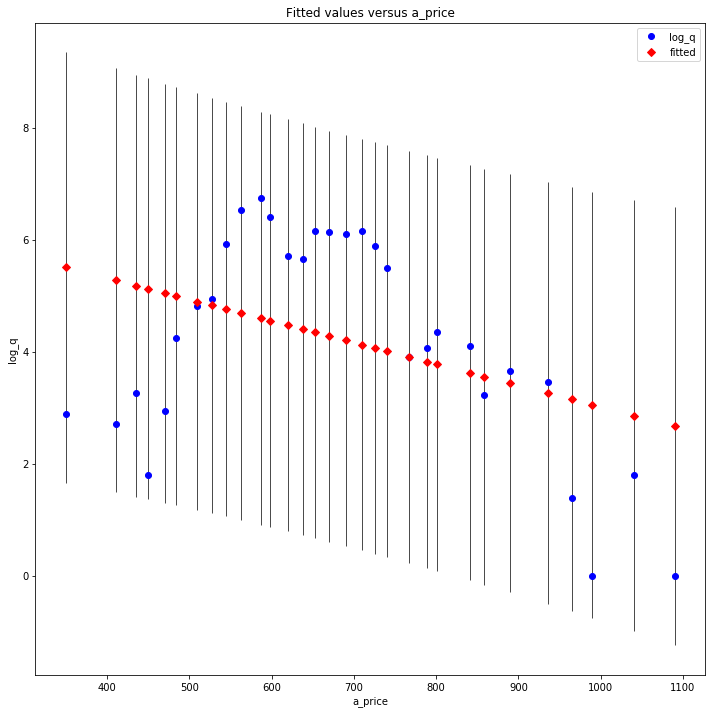

In [1095]:
fix, ax = plt.subplots(figsize=(12,12))
fig = sm.graphics.plot_fit(ols_linear, 'a_price', data=temp, ax=ax)

In [1096]:
# Третья функция - линейная с негативным наклоном
c = ols_linear.params.get('Intercept')
a = ols_linear.params.get('a_price')

lnq = c - 1

p = (lnq - c) / a

print(f'Цена для максимизации прибыли согласно линейной функции: p = {p} при продаже {lnq**np.e} билетов') 

Цена для максимизации прибыли согласно линейной функции: p = 260.67325139873174 при продаже 121.6709062633113 билетов


In [1097]:
print(roots1)
print(roots2)
print(roots3)
print(roots4)
print(p)

(274.2287816273505, 1054.8038980485892)
(63.84262517638639, 703.9145703818156)
648.7989899724918
1123.1090573983645
260.67325139873174
